### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
TEST_YEAR = 2019

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

In [6]:
RANDOM_STATE = 0 # no difference for LightGBM?

# Load best model

In [7]:
params = get_best_parameters('lightgbm-simple-cv-test', 'lightgbm')

WIS of best run: 185.67070007218177


In [8]:
name = params.pop('model')
test_year = params.pop('test_year')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')

In [9]:
if not use_covariates:
    del params['lags_past_covariates']

In [10]:
params

{'lags': 16,
 'max_bin': 1024,
 'max_depth': 5,
 'reg_alpha': 0,
 'subsample': 1,
 'num_leaves': 40,
 'reg_lambda': 0,
 'n_estimators': 5000,
 'learning_rate': 0.05,
 'min_split_gain': 0,
 'subsample_freq': 0,
 'colsample_bytree': 1,
 'min_child_samples': 30,
 'lags_past_covariates': 8,
 'use_static_covariates': True,
 'lags_future_covariates': [0, 4]}

In [11]:
model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1,
    random_state=RANDOM_STATE
)

# Load data

In [12]:
targets_train, targets_validation, covariates = get_test_data(TEST_YEAR)

<Axes: xlabel='date'>

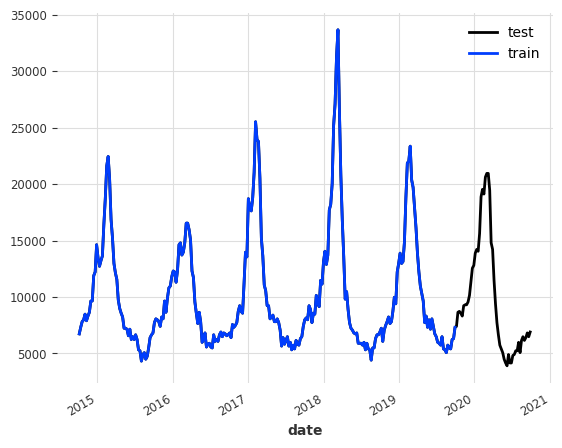

In [13]:
targets_validation['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

In [14]:
if multiple_series:
    train = [targets_train[col] for col in targets_train.columns]
    validation = [targets_validation[col] for col in targets_validation.columns]
else:
    train = targets_train
    validation = targets_validation

if use_features:
    ts_features = load_features(lag=8)
    cov = covariates.slice_intersect(ts_features) # features start a bit later because of rolling window
    ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    if multiple_series:
        ts_features = [ts_features[[col for col in ts_features.columns if target in col]] for target in TARGETS] # has to be in the same order as the target series!
        cov = [concatenate([cov.with_static_covariates(None), features_age], axis='component') for features_age in ts_features]
    else:
        cov = concatenate([cov.with_static_covariates(None), ts_features], axis='component')
else:
    if multiple_series:
        cov = [covariates]*len(train)
    else:
        cov = covariates

# Train model

In [18]:
HFC_PATH = f'../data/pre-covid/{name}0-{test_year}.csv'
MODEL_PATH = f'../models/pre-covid/{name}0-{test_year}.pt'

In [19]:
MODEL_PATH

'../models/pre-covid/lightgbm0-2019.pt'

In [17]:
model.fit(targets_train, past_covariates=covariates if use_covariates else None)

LightGBMModel(lags=16, lags_past_covariates=8, lags_future_covariates=[0, 4], output_chunk_length=4, output_chunk_shift=0, add_encoders={'datetime_attribute': {'future': ['month', 'weekofyear']}}, likelihood=quantile, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], random_state=0, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None, max_bin=1024, max_depth=5, reg_alpha=0, subsample=1, num_leaves=40, reg_lambda=0, n_estimators=5000, learning_rate=0.05, min_split_gain=0, subsample_freq=0, colsample_bytree=1, min_child_samples=30, verbose=-1)

In [20]:
model.save(MODEL_PATH)

In [21]:
# LightGBMModel.load(MODEL_PATH)

# Compute historical forecasts

In [22]:
if multiple_series:
    validation_start = targets_train[0].end_time() + targets_train[0].freq
else:
    validation_start = targets_train.end_time() + targets_train.freq

In [23]:
hfc = model.historical_forecasts(
    series=targets_validation,
    past_covariates=covariates if use_covariates else None,
    start=validation_start,
    forecast_horizon=HORIZON,
    stride=1,
    last_points_only=False,
    retrain=False,
    verbose=False,
    num_samples=NUM_SAMPLES,
    enable_optimization=False
)

In [24]:
df = reshape_hfc(hfc)

In [25]:
df.to_csv(HFC_PATH, index=False)
print(HFC_PATH)

../data/pre-covid/lightgbm0-2019.csv


In [26]:
# df = pd.read_csv(HFC_PATH)

# Plot historical forecasts

In [27]:
if multiple_series:
    df_plot = prepare_plot_data(df, concatenate(targets_validation, axis='component')[test_start : ])
else:
    df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

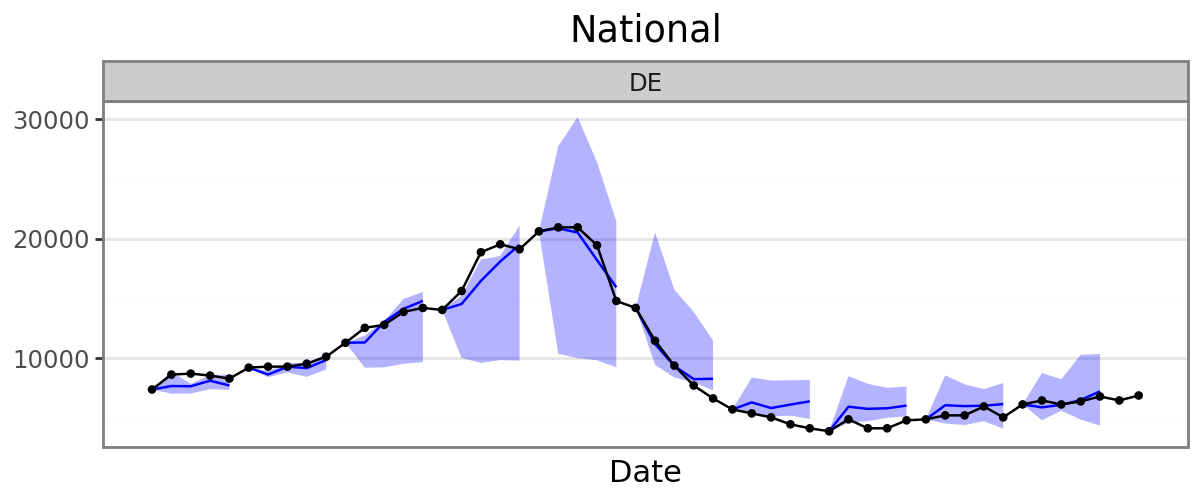

In [30]:
plot_forecasts(df_plot, 'national', start=1)

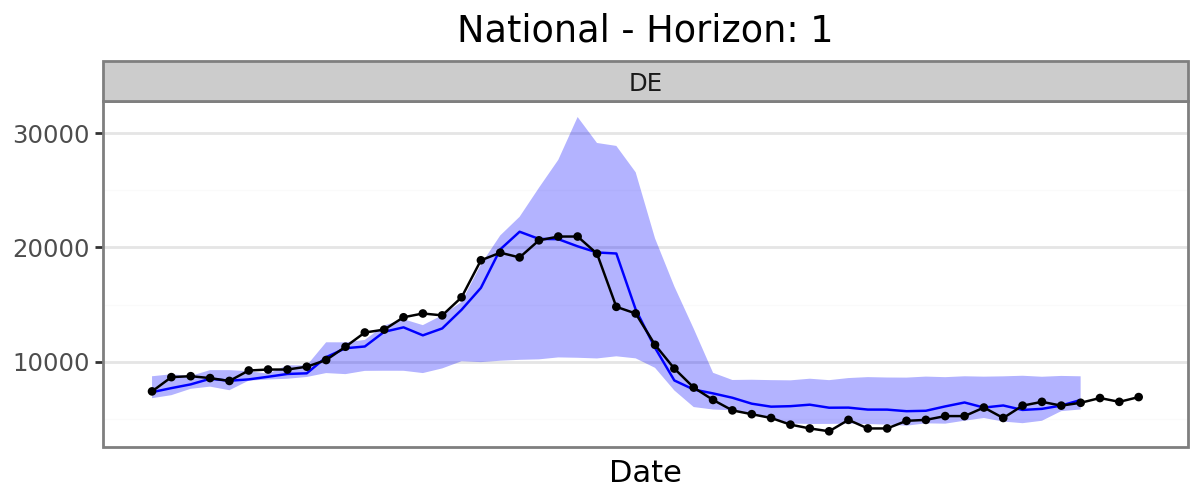

In [117]:
plot_forecasts(df_plot, 'national', horizon=1)

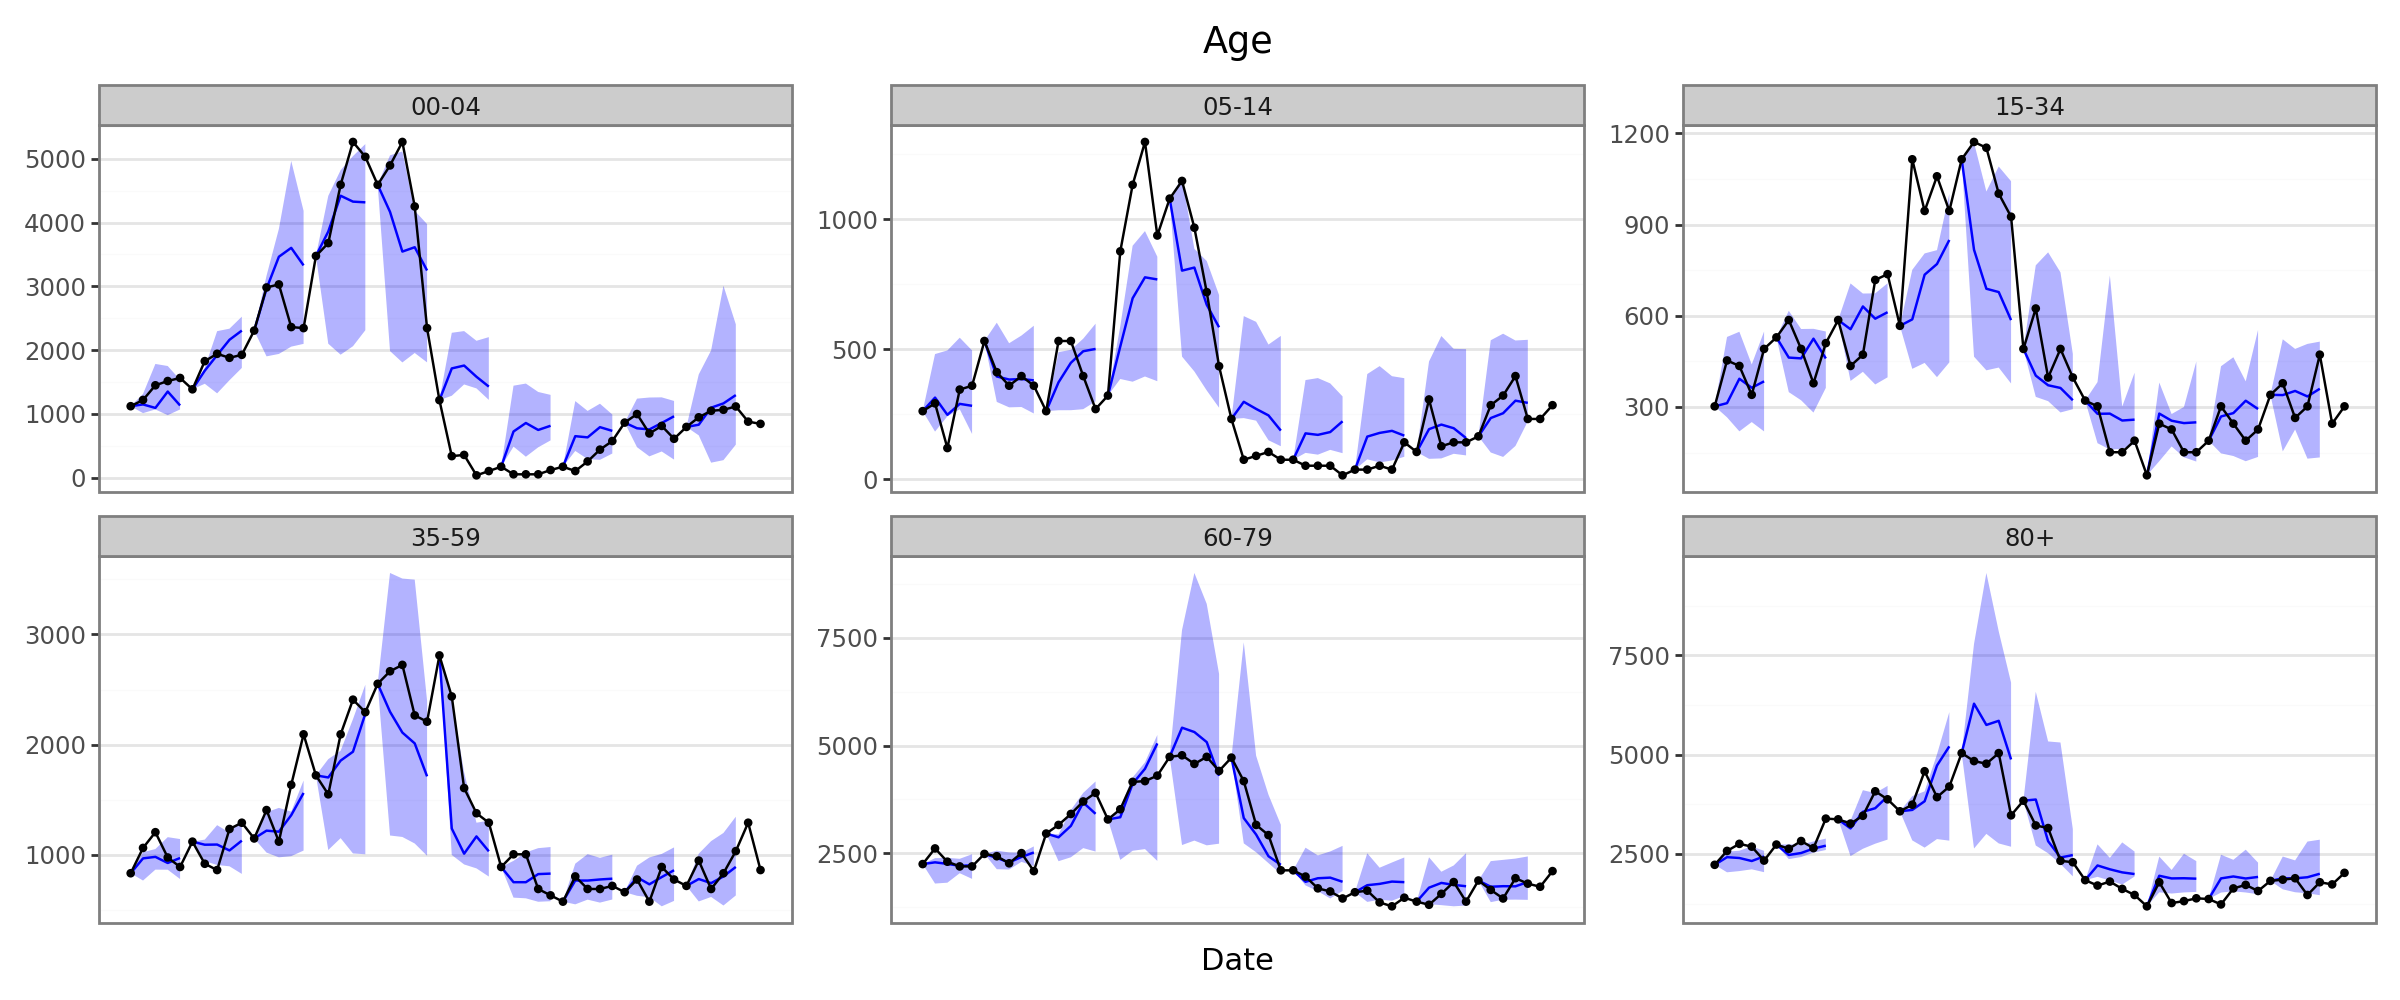

In [107]:
plot_forecasts(df_plot, 'age', start=1)

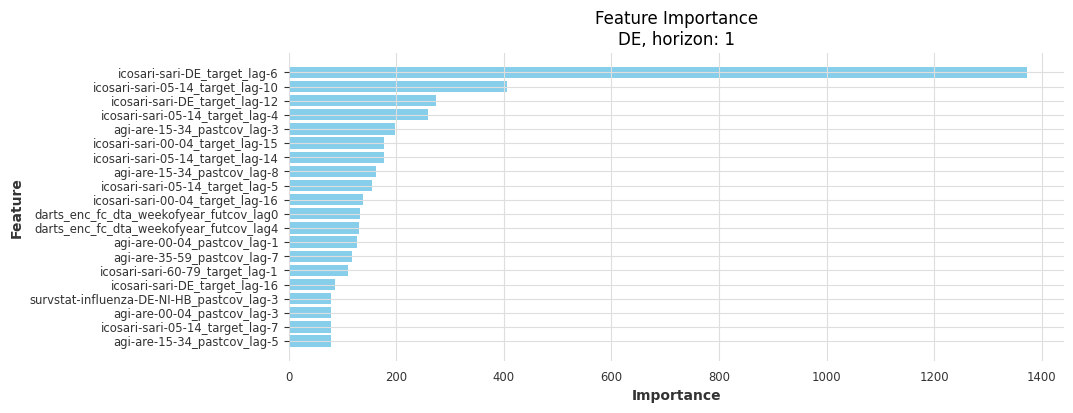

In [118]:
plot_importance_lgbm(model, age_group='00+', horizon=1, max_features=20, y_size=4)

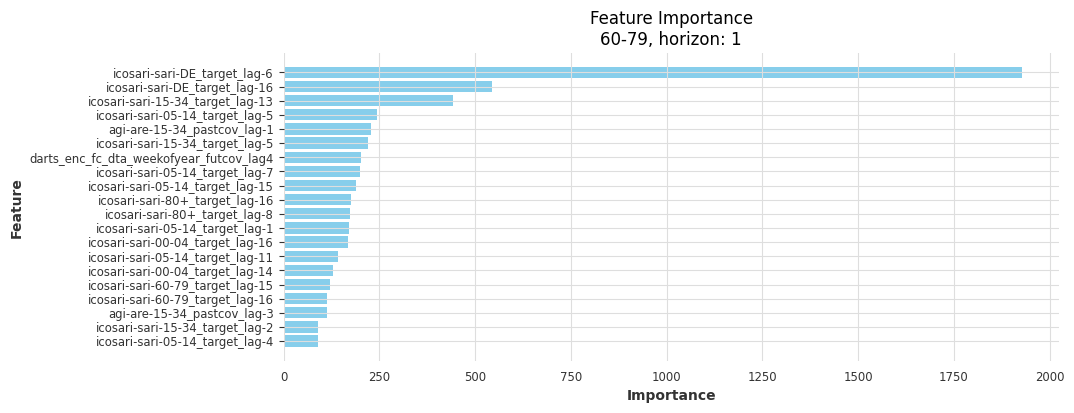

In [120]:
plot_importance_lgbm(model, age_group='60-79', horizon=1, max_features=20, y_size=4)